#GPU Information

In [ ]:
!nvidia-smi

Fri Sep 17 13:42:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import libs

In [ ]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
import os
import time
from scipy.sparse.csr import csr_matrix as spare_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import sparse 

#Introduction

Trong phần này, em sẽ tập trung việc giải bài toán news classification bằng phương pháp thuần Machine Learning.

Cụ thể, em sẽ sử dụng phương pháp Bag-of-Words (BoW) kết hợp với TF-IDF để trích chọn đặc trưng của văn bản (feature extractor)

Bên cạnh đó, em sẽ sử dụng 3 classifier sau:

  1. Naive Bayes
  2. Logistic Regression
  3. Support Vector Machine

Bây giờ, em sẽ đi vào từng phương pháp một. 

#Load data

Đầu tiên là cần load lại dữ liệu đã tiền xử lý ở bước trước.

In [ ]:
# Đường dẫn
train_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_x.sav'
train_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/train_y.sav'
test_x_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_x.sav'
test_y_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/test_y.sav'

In [ ]:
# load data
train_x = pickle.load(open(train_x_path, 'rb'))
train_y = pickle.load(open(train_y_path, 'rb'))
test_x = pickle.load(open(test_x_path, 'rb'))
test_y = pickle.load(open(test_y_path, 'rb'))

In [ ]:
# load labels
labels = os.listdir('/content/drive/MyDrive/The Anh Tran/Final Coursework/Data/Train')
print('Number of labels: ', len(labels))
labels = sorted(labels)
labels

Number of labels:  27


['Am nhac',
 'Am thuc',
 'Bat dong san',
 'Bong da',
 'Chung khoan',
 'Cum ga',
 'Cuoc song do day',
 'Du hoc',
 'Du lich',
 'Duong vao WTO',
 'Gia dinh',
 'Giai tri tin hoc',
 'Giao duc',
 'Gioi tinh',
 'Hackers va Virus',
 'Hinh su',
 'Khong gian song',
 'Kinh doanh quoc te',
 'Lam dep',
 'Loi song',
 'Mua sam',
 'My thuat',
 'San khau dien anh',
 'San pham tin hoc moi',
 'Tennis',
 'The gioi tre',
 'Thoi trang']

#Các phương pháp phân loại

##1. Naive Bayes

Một phương pháp ứng dụng định lý Bayes để giải quyết bài toán phân loại $C$ nhãn bằng cách tính xác suất để điểm dữ liệu rơi vào nhãn $c$ với $c \in (1, C)$.

Tương đương với tính $P(y=c|x)$. Bằng cách tính xác xuất một điểm dữ liệu $x$ rơi vào các nhãn đã cho, ta có thể tìm được $c'$ sao cho xác suất $x$ rơi vào $c'$ là cao nhất trong các nhãn. Để thuận tiện cho việc tính toán, bài toán đặt ra giả thiết ngây thơ là tất cả các thành phần của $x$ sẽ đôi một độc lập với nhau. Mặc dù điều kiện này là quá chặt trong thực tế, tuy nhiên trong nhiều bài toán, nó lại đem lại kết quả khả quan. Hơn nữa mô hình sử dụng Naive Bayes có tốc độ train và test rất nhanh.

Có 3 phương pháp Naive Bayes là Gaussian NB, Multinomial NB và Bernoulli NB. Trong trường hợp này, em sẽ dùng Multinomial NB kết hợp với TF-IDF.

**Đôi chút về TF-IDF:** TF-IDF (Term Frequency - Inverse Document Frequency) là một kỹ thuật sử dụng trong khai phá dữ liệu văn bản. Kỹ thuật này nhằm tính toán ra một trọng số để đánh giá tầm quan trọng của một từ đối với văn bản gốc. Trọng số cao đồng nghĩa với việc từ đó có giá trị cao trong văn bản gốc. Giá trị này tỉ lệ thuận với số lần xuất hiện trong văn bản và tỉ lệ nghịch với tần suất xuất hiện của từ đó trong toàn bộ tập dữ liệu. Phương pháp này cũng thường được dùng để phát hiện stop words trong tập dữ liệu.

In [ ]:
# Train model
mnb = Pipeline([
               # convert dataset sang dạng vector count dựa trên một vocab chung (BoW), loại bỏ những word có tần suất xuất hiện > 0.8
               ('vectorize', CountVectorizer(max_df=0.8, encoding='utf-16')),
               # áp dụng tf-idf để extract feature
               ('feature extracter', TfidfTransformer()),
               # áp dụng Multinomial NB để phân loại
               ('classifier', MultinomialNB())
])

start = time.time()
mnb.fit(train_x, train_y)
print('Multinomial Bayes finish training after %d seconds.' %(time.time() - start))

nb_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/MultinomialNB.sav'
pickle.dump(mnb, open(nb_path, 'wb'))

Multinomial Bayes finish training after 3 seconds.


In [ ]:
# Đánh giá model
pred_y = mnb.predict(test_x)

score = np.mean(pred_y == test_y)
print('Multinomial Naive Bayes score: ', score)

Multinomial Naive Bayes score:  0.7096720768466379


In [ ]:
# Đánh giá lỗi trên từng nhãn
print(classification_report(test_y, pred_y, zero_division=1))

                      precision    recall  f1-score   support

             Am nhac       0.62      0.92      0.74       813
             Am thuc       1.00      0.54      0.70       400
        Bat dong san       1.00      0.57      0.72       282
             Bong da       0.64      1.00      0.78      1464
         Chung khoan       0.99      0.89      0.94       320
              Cum ga       0.99      0.98      0.98       381
    Cuoc song do day       0.84      0.32      0.46       405
              Du hoc       0.96      0.92      0.94       394
             Du lich       0.89      0.79      0.84       565
       Duong vao WTO       1.00      0.10      0.19       191
            Gia dinh       1.00      0.00      0.00       280
    Giai tri tin hoc       0.70      0.66      0.68       707
            Giao duc       0.73      0.93      0.82       707
           Gioi tinh       1.00      0.41      0.58       268
    Hackers va Virus       1.00      0.54      0.70       319
       

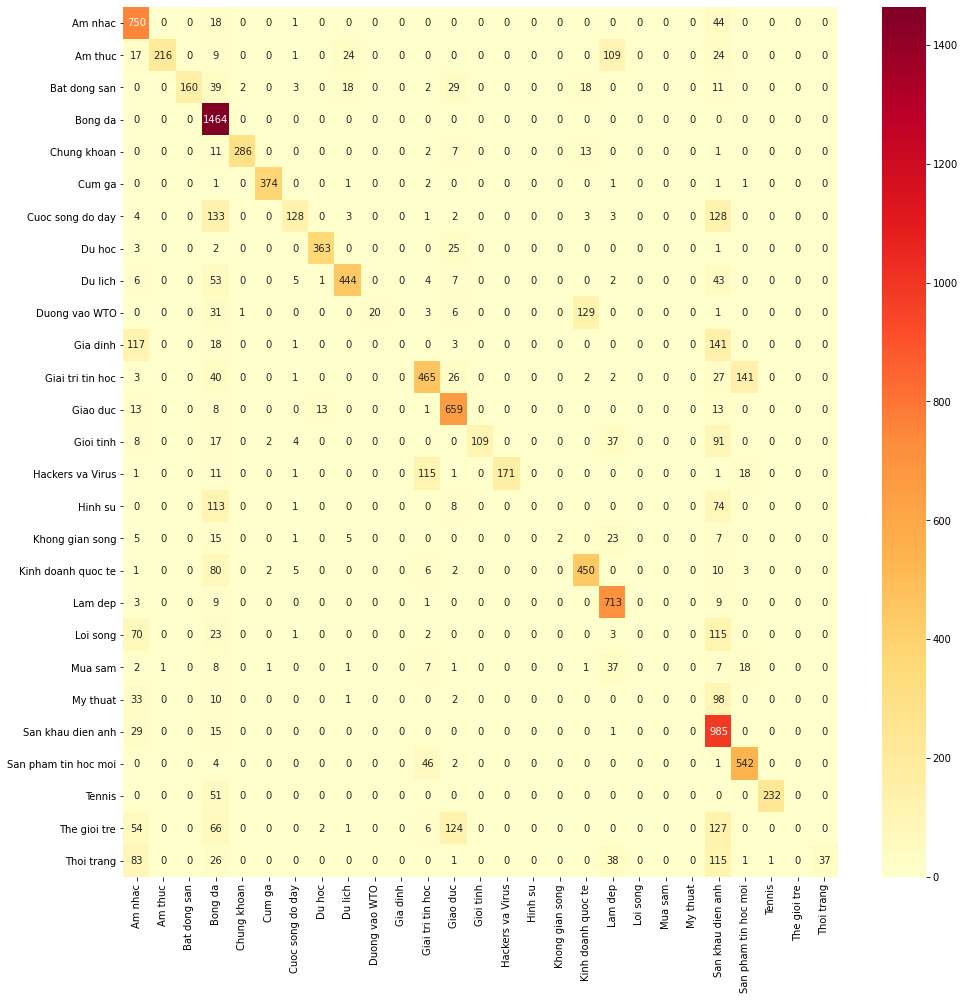

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(16, 16))
conf_matrix = confusion_matrix(test_y, pred_y, labels=labels)
sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

**Nhận xét:** Do phương pháp này dựa trên một giả thiết ngây thơ,khó xảy ra trong thực tế và đặc biệt khó xảy ra trong văn bản (các từ độc lập với nhau) nên khó có thể đạt được độ chính xác cao trong điều kiện thực tế.

Mô hình đạt độ chính xác trung bình là **70.97%**

##2. Logistic Regression


Phương pháp này sử dụng TF-IDF cho phần trích chọn đặc trưng và sử dụng Logistic Regression cho phần phân loại. Độ chính xác của Logistic Regression sẽ phụ thuộc phần lớn vào khả năng phân cụm của bộ trích chọn đặc trưng.

In [ ]:
lgres = Pipeline([
                  # Chuyển đầu vào về vector tần số (BoW)
                  ('vectorize', CountVectorizer(max_df=0.8, encoding='utf-16')),
                  # Sử dụng TF-IDF
                  ('feature extracter', TfidfTransformer()),
                  # Dùng Logistic Regression để classify
                  ('classifier', LogisticRegression(max_iter=100_000))
])

start = time.time()
lgres.fit(train_x, train_y)
print('Logistic Regression finish training after ', time.time() - start)

Logistic Regression finish training after  64.836106300354


In [ ]:
# save model
lr_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/LogisticRegression.sav'
pickle.dump(lgres, open(lr_path, 'wb'))

In [ ]:
# Đánh giá model
pred_y = lgres.predict(test_x)

score = np.mean(pred_y == test_y)
print('Logistic Regression score: ', score)

Logistic Regression score:  0.9011262007287181


In [ ]:
# Đánh giá lỗi trên từng nhãn
print(classification_report(test_y, pred_y, zero_division=1))

                      precision    recall  f1-score   support

             Am nhac       0.93      0.92      0.93       813
             Am thuc       0.99      0.92      0.95       400
        Bat dong san       0.98      0.94      0.96       282
             Bong da       0.99      0.99      0.99      1464
         Chung khoan       0.99      0.95      0.97       320
              Cum ga       1.00      0.98      0.99       381
    Cuoc song do day       0.57      0.92      0.70       405
              Du hoc       0.97      0.92      0.94       394
             Du lich       0.91      0.97      0.94       565
       Duong vao WTO       0.99      0.77      0.87       191
            Gia dinh       0.88      0.51      0.65       280
    Giai tri tin hoc       0.78      0.88      0.83       707
            Giao duc       0.90      0.94      0.92       707
           Gioi tinh       0.88      0.91      0.89       268
    Hackers va Virus       0.99      0.86      0.92       319
       

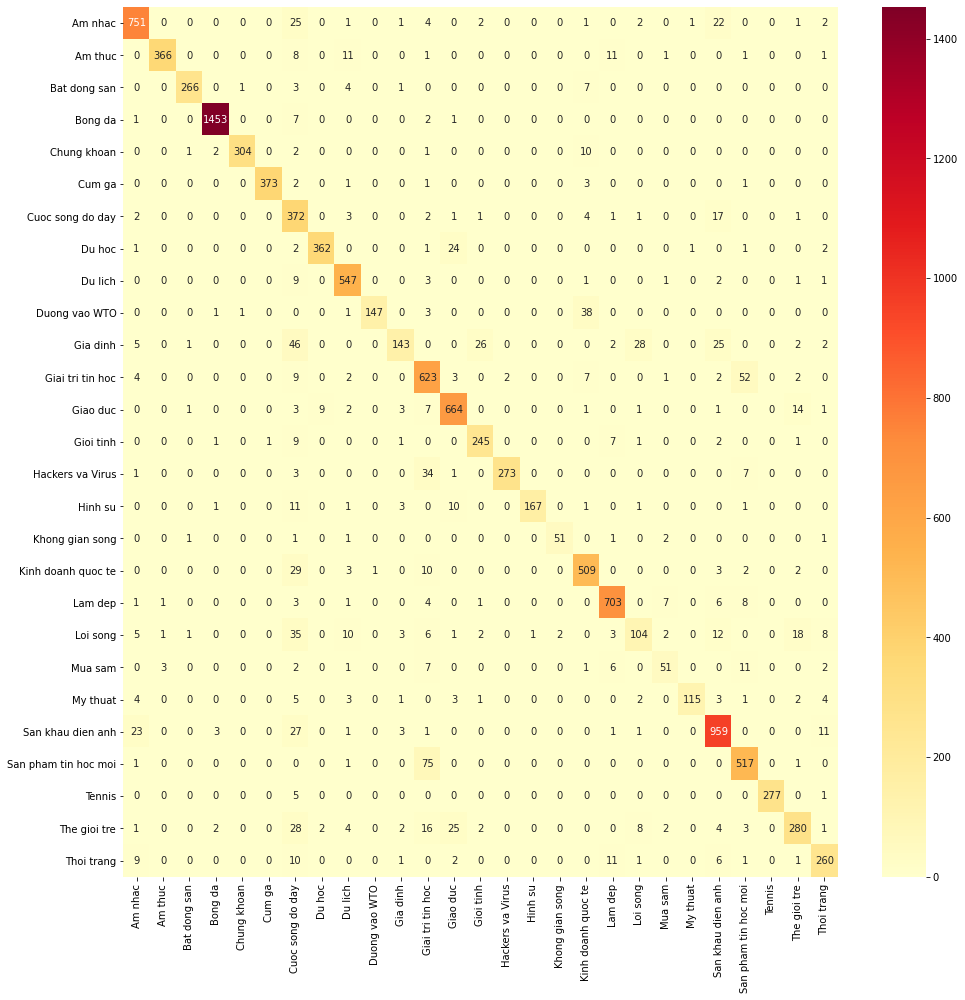

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(16, 16))
conf_matrix = confusion_matrix(test_y, pred_y, labels=labels)
sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd', xticklabels=labels, yticklabels=labels)

**Nhận xét:** Mô hình sử dụng Logistic Regression cho kết quả tốt hơn hẳn so với mô hình sử dụng Naive Bayes, cụ thể là **90.11%**. Tuy nhiên thời gian train và test lâu hơn hẳn. Mô hình gặp lỗi nhiều với topic 'Cuộc sống đó đây'. Khá dễ hiểu vì chủ đề này khá rộng và bao quát, dễ nhầm lẫn sang những chủ đề còn lại. Tóm lại, mô hình Logistic Regression cho kết quả khá tốt.

##3. Support Vector Machine

Mô hình cũng sử dụng TF-IDF làm feature extractor và dùng SVM làm classifier.

In [ ]:
# train model
svm = Pipeline([
                # BoW
                ('vectorize', CountVectorizer(max_df=0.8)),
                # TF-IDF
                ('feature extractor', TfidfTransformer()),
                # SVM
                ('classifier', SVC())
])

start = time.time()
svm.fit(train_x, train_y)
print('Support Vector Machine finish training after %d seconds' %(time.time() - start))

# save model
svm_path = '/content/drive/MyDrive/The Anh Tran/Final Coursework/Saved/SVM.sav'
pickle.dump(svm, open(svm_path, 'wb'))

Support Vector Machine finish training after 337 seconds


In [ ]:
# Đánh giá model
pred_y = svm.predict(test_x)

score = np.mean(pred_y == test_y)
print('Support Vector Machine score: ', score)

Support Vector Machine score:  0.895163961576681


In [ ]:
# Đánh giá lỗi trên từng nhãn
print(classification_report(test_y, pred_y, zero_division=1))

                      precision    recall  f1-score   support

             Am nhac       0.95      0.89      0.92       813
             Am thuc       0.98      0.92      0.95       400
        Bat dong san       1.00      0.93      0.96       282
             Bong da       1.00      0.99      0.99      1464
         Chung khoan       0.99      0.93      0.96       320
              Cum ga       1.00      0.95      0.97       381
    Cuoc song do day       0.46      0.94      0.62       405
              Du hoc       0.99      0.92      0.95       394
             Du lich       0.93      0.95      0.94       565
       Duong vao WTO       1.00      0.82      0.90       191
            Gia dinh       0.86      0.52      0.65       280
    Giai tri tin hoc       0.77      0.91      0.83       707
            Giao duc       0.91      0.94      0.93       707
           Gioi tinh       0.90      0.88      0.89       268
    Hackers va Virus       0.99      0.88      0.93       319
       

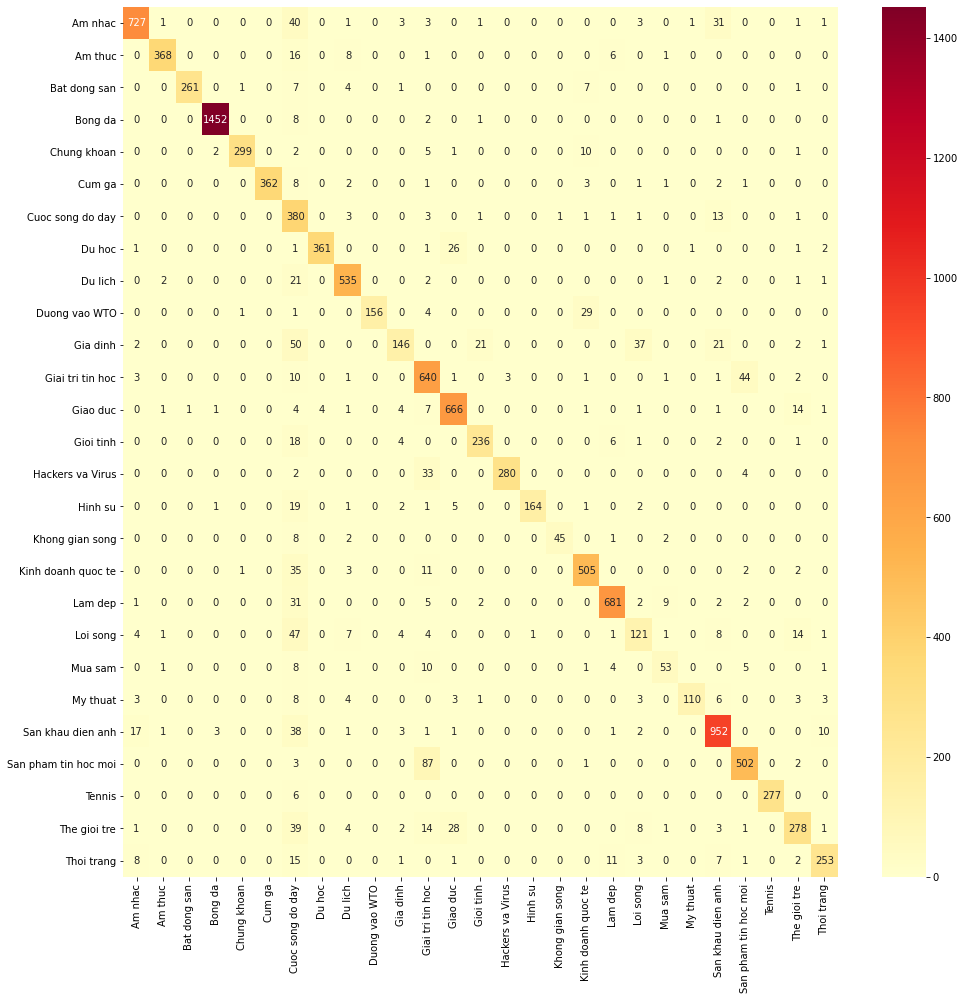

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(16, 16))
conf_matrix = confusion_matrix(test_y, pred_y, labels=labels)
sb.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd', xticklabels=labels, yticklabels=labels)

**Nhận xét:** Thời gian train của SVM lâu hơn khá nhiều so với những mô hình còn lại. Hơn nữa độ chính xác thấp hơn 1 chút so với Logistic Regression. Mô hình này tiếp tục dự đoán sai nhiều trong topic 'Cuộc sống đó đây'. Có thể nhận định, đây là một topic khó để classify.

#Tổng kết

So sánh kết quả giữa 3 mô hình khác nhau trong điều kiện cùng sử dụng feature extractor là BoW + TF-IDF và cùng bộ dữ liệu giống nhau.
  
  - **Multinomial Naive Bayes:**
    
    + Accuracy: 70.97%
    + Training time: 4.0 sec
    + Test speed: High

  - **Logistic Regression:**

    + Accuracy: 90.11%
    + Training time: 64.8 sec
    + Test speed: Medium

  - **SVM:**

    + Accuracy: 89.52%
    + Training time: 337.0 sec
    + Test speed: Low


**Kết luận:** Logistic Regression cho kết quả tốt nhất với thời gian train không quá lâu.

**Chú ý:** Một số topic khá giống nhau, chẳng hạn như 'Sản phẩm tin học mới' và 'Giải trí tin học', và cũng có những chủ để khá rộng, có thể giống nhiều chủ đề khác như 'Cuộc sống đó đây' dễ bị nhầm sang 'Lối sống', 'Gia đình', 'Âm nhạc', ... Do đó, với độ chính xác hơn 90% cũng đã là khá tốt đối với các mô hình Machine Learning.

**Nhận xét:** Việc phân loại văn bản khá tốt vì việc sử dụng BoW + TF-IDF đã trích xuất được những đặc trưng cần thiết cho việc phân loại văn bản (liên quan đến tần số xuất hiện của một từ). Trong thực tế, chúng ta cũng thường hay phân loại văn bản dựa trên những từ quan trọng (keyword) trong văn bản đó. Tuy nhiên, việc sử dụng BoW + TF-IDF lại bỏ quan một đặc điểm quan trọng văn bản, đó là tính tuần tự, ngữ cảnh, ngữ nghĩa, cảm xúc trong câu từ (do chỉ dựa vào tần số xuất hiện của mỗi từ). Vì vậy, nếu cải tiến bộ feature extractor trong mô hình sao cho tận dụng được những đặc tính này của các từ trong văn bản thì việc phân loại có thể đạt được hiệu quả cao hơn. Do đó, trong phần tiếp theo, em sẽ tập trung vào việc xây dựng bộ trích chọn đặc trưng mới cho văn bản.

**Mô hình hóa những đặc trưng đã được trích chọn bằng BoW + TF-IDF**


In [ ]:
# Bộ trích chọn sử dụng TF-IDF
extractor = Pipeline([
                ('vectorize', CountVectorizer(max_df=0.8, )),
                ('feature extractor', TfidfTransformer())
])

start = time.time()
extractor.fit(train_x, train_y)
print('Feature extractor finish training after %d seconds' %(time.time() - start))

Feature extractor finish training after 3 seconds


In [ ]:
# Feature extract được
features = extractor.transform(test_x)
type(features)

scipy.sparse.csr.csr_matrix

In [ ]:
# Embed feature ra thành vector 2 chiều để visualize
# encode output
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(test_y)

tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(features)
print('Embedded shape: ', x_2d.shape)

Embedded shape:  (12076, 2)


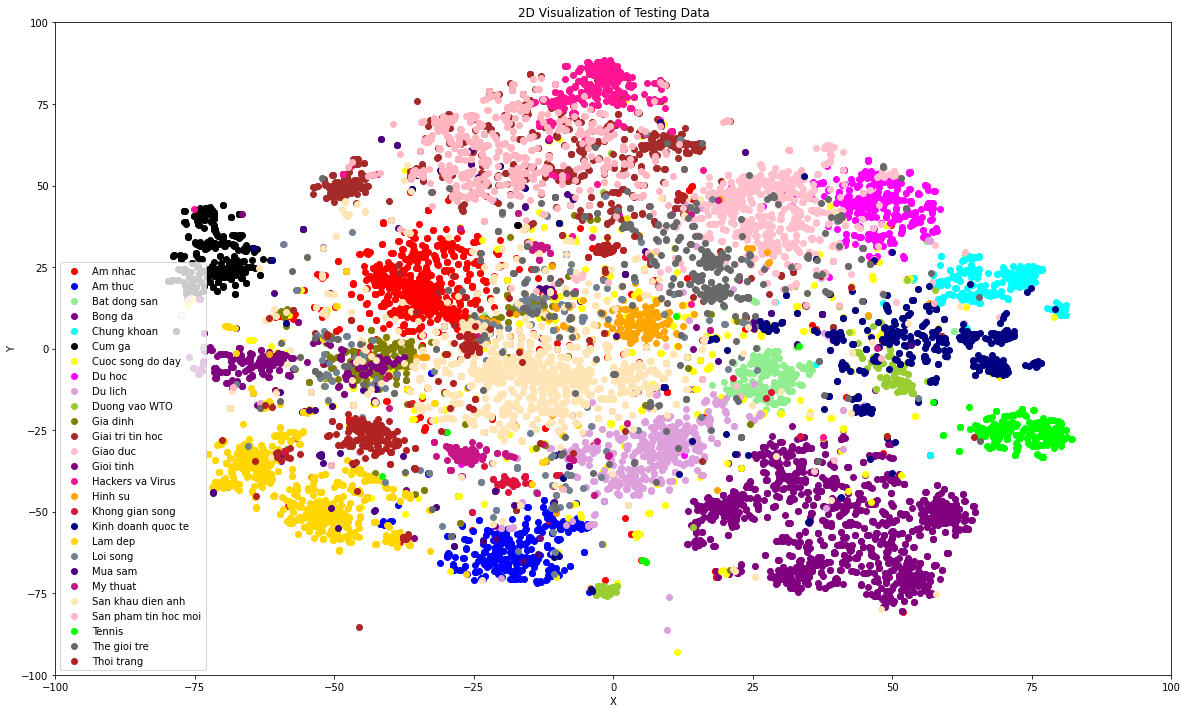

In [ ]:
# visualize
plt.figure(figsize=(20, 12))
color_map = {
    0: 'red', 1: 'blue', 2: 'lightgreen', 3: 'purple', 4: 'cyan', 5: 'black', 6: 'yellow', 7: 'magenta',
    8: 'plum', 9: 'yellowgreen', 10: 'olive', 11: 'brown', 12: 'pink', 13: 'purple', 14: 'deeppink', 
    15: 'orange', 16: 'crimson', 17: 'navy', 18: 'gold', 19: 'greenyellow', 19: 'aquamarine', 19: 'slategrey',
    20: 'indigo', 21: 'mediumvioletred', 22: 'moccasin', 23: 'lightpink', 24: 'lime', 25: 'dimgrey', 26: 'firebrick'
}

test_y = np.array(test_y)

for idx, label in enumerate(labels):
  plt.scatter(x=x_2d[test_y == label, 0], y=x_2d[test_y == label, 1], c=color_map[idx], marker='o', label=label)

plt.xlabel('X')
plt.ylabel('Y')
plt.axis([-100, 100, -100, 100])
plt.legend()
plt.title('2D Visualization of Testing Data')
plt.show()

**Nhận xét:** Dựa trên hình thì việc extract feature bằng BoW + TF-IDF cũng đã là khá tốt khi dữ liệu được phân thành các cụm khá rõ rệt. Tiếp theo, em sẽ thử với những mô hình feature extractor phức tạp hơn.